## Pràctica 6
### Gestió de residus


In [76]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Math, display
import sympy as sp
from sympy.physics.units.systems import SI
from sympy.physics.units import meter, second, liter, hour, degree, convert_to
from sympy import sin, cos, pi, Abs

sp.init_printing()

def show(*args,sep=False):
    out = ""
    for arg in args:
        if isinstance(arg, (sp.Expr, sp.Eq)):
            arg = sp.latex(arg)
        else:
            arg = str(arg)
        out += arg
        if(sep):
            out += qq
    display(Math(out))

    
qq = "\quad "

## Gestió de residus
- Tenim una planta de gestió de residus i hem de limitar la concentració d'un reactiu
- El nostre reactor està compost de 2 dipòsits connectats en sèrie amb un cabal continu.
- Volem saber quin ha de ser el cabal d'aigua per no superar a la sortida una concentració de $0.05 \pm 0.01\, mg/l$ amb un CL del 99%
- Al primer dipòsit es carrega el reactiu
- Del primer dipòsit passen al segon i d'ací surten cap a la següent fase.
- El volum dels dipòsits és de $100.0 \pm 0.1 \,m^3$
- Cada càrrega és de $80.0 \pm 0.1 \,g$ de reactiu
- El reactiu té una taxa de descomposició de $0.10 \pm 0.01\, min^{-1}$ reaccions per segon

### Dades
- Per validar el model hem contractat un laboratori d'assaigs que ha fet les següents mesures:
    - Volum d'aigua dels tancs de proves $1.0000 \pm 1\times10^{-4} m^3$
    - Concentració inicial $10.0 \pm 0.1 \,mg/l$
    - Flux d'aigua $60.000 \pm 0.001 \,l/s$

Index(['t (min)', 'Concentració (mg/l)', 'Flux (l/min)'], dtype='object')


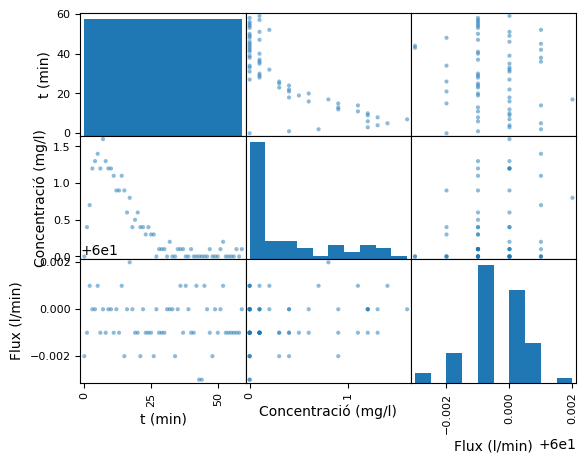

In [77]:
# Dades
# data = pd.read_csv("../data/reactiu.csv")
data = pd.read_csv("reactiu.csv")
print(data.columns)
l = pd.plotting.scatter_matrix(data[data.columns])

## Apartats
- Descriu i analitza el sistema rellevant per a l'estudi (5 punts)
- Fes les assumpcions pertinents i argumenta-les adequadament (5 punts)
- Modelitza i resol el model (10 punts)
- Verifica i valida el model (10 punts)
- Fes una anàlisi crítica dels resultats (5 punts)

## Anàlisi del sistema

### Context

### Paràmetres

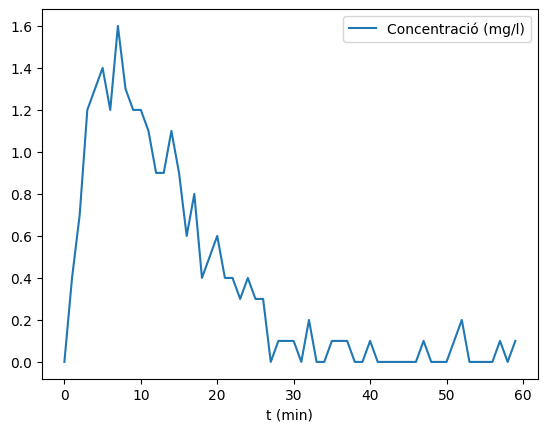

In [78]:
# Visualització de dades
l = data.plot(x="t (min)", y="Concentració (mg/l)")

## Assumpcions

- Estudiem la composicio de cada diposit per separat
- La disminuició del reacriu sera proporcional a la concentracio del reactiu al diposit i a la taxa de descomposicio del reactiu
- Al segon diposit tindrem un augment de reactiu proporcional al cabal d'aigua entrant i a la concentració de reactiu al primer diposit

$$ x'_1 = -x_1 \cdot Q/V - x_1R $$
$$ x'_2 = x_1 \cdot Q/V -x_2 \cdot Q/V - x_2R $$

## Modelització

In [79]:
from sympy.abc import t,a,b,c,d,C,Q,R,V
Q = sp.Symbol("Q",nonzero=1, positive=1)

x1 = sp.Function('x_1')(t)
x2 = sp.Function('x_2')(t)

x1p = sp.diff(x1,t)
x2p = sp.diff(x2,t)

fx1 = - x1 * Q/V - x1*R
fx2 = x1 * Q/V - x2 * Q/V - x2*R  

eq1 = sp.Eq(x1p,fx1)
eq2 = sp.Eq(x2p,fx2)

ics = {x1.subs(t,0):C, x2.subs(t,0):0}

sol = sp.dsolve([eq1,eq2],[x1,x2],ics=ics)
x1t = sol[0].rhs
x2t = sol[1].rhs

show(x1t,qq,x2t)

# sp.dsolve()



<IPython.core.display.Math object>

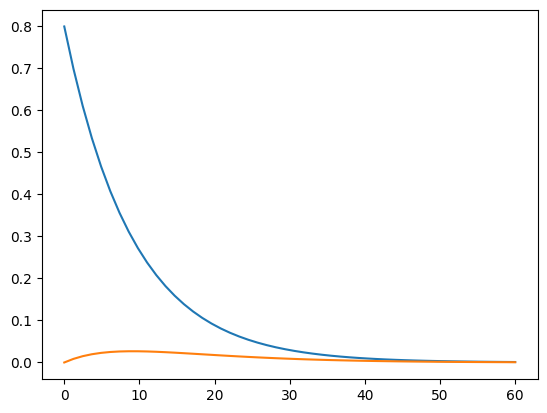

In [80]:
valors = {R:0.1, C:0.8 , V:1e5}
par = {Q: 1e3}

fx1t = sp.lambdify(t, x1t.subs(valors).subs(par))
fx2t = sp.lambdify(t, x2t.subs(valors).subs(par))

temps = np.linspace(0,60,50)

plt.plot(temps,fx1t(temps),label='x1')
plt.plot(temps,fx2t(temps),label = 'x2')

In [81]:
# Derivada de x_2 per cercar el màxim
x2t.diff(t).simplify()

                       -t⋅(Q + R⋅V) 
                       ─────────────
                             V      
C⋅Q⋅(V - t⋅(Q + R⋅V))⋅ℯ             
────────────────────────────────────
                  2                 
                 V                  

In [82]:
# Temps on s'ariba al màxim
tmax = sp.solve(x2t.diff(t),t)[0]
tmax

   V   
───────
Q + R⋅V

In [83]:
# Concentracio en el punt màxim
Ctmax = x2t.subs(t,tmax)
Ctmax

     -1
C⋅Q⋅ℯ  
───────
Q + R⋅V

In [84]:
# Cabal òptim per una concentració màxima donada
Cmax = sp.Symbol('C_{max}')
Qop = sp.solve(Ctmax - Cmax,Q)[0]
Qop

ℯ⋅C_{max}⋅R⋅V
─────────────
C - ℯ⋅C_{max}

In [85]:
# Cabal òptim per una concentració màxima de R = 0.05
Qop.subs(valors).subs(Cmax,0.05).n(4)

2047.

Coeficients de sensitivitat del model

In [86]:
valors = {Cmax: 0.05, R: 0.1, V: 0.1, C: 0.8}

CL = Cmax/Qop * sp.diff(Qop, Cmax)
CR = R / Qop * sp.diff(Qop, R)
CV = V / Qop * sp.diff(Qop, V)
CC = C / Qop * sp.diff(Qop, C)
show(CL.subs(valors).n(),CR,CV,CC.subs(valors).n(),sep=True)

<IPython.core.display.Math object>

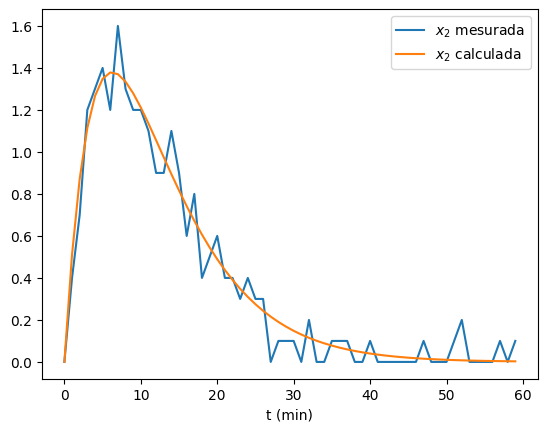

In [87]:
# Simulació
valors = {R: 0.1, C: 10, V: 1e3}

fx2t = sp.lambdify((t,Q),x2t.subs(valors))

temps = data['t (min)']
x2tS = fx2t(temps,data['Flux (l/min)'])

data.plot(x='t (min)', y='Concentració (mg/l)')
plt.plot(temps,x2tS)
plt.legend(['$x_2$ mesurada', '$x_2$ calculada'])
plt.show()

In [88]:
# Derivades Parcials
mesures = {Q: data['Flux (l/min)'].mean()}

SC = sp.diff(x2t, C).subs(valors).subs(mesures).n()
SQ = sp.diff(x2t, Q).subs(valors).subs(mesures).n()
SR = sp.diff(x2t, R).subs(valors).subs(mesures).n()
SV = sp.diff(x2t, V).subs(valors).subs(mesures).n()


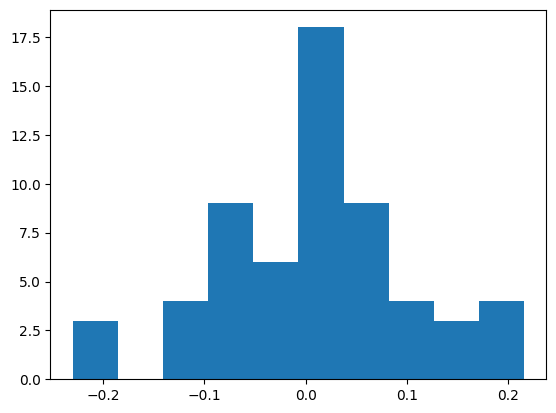

In [89]:
# Discrepancia
# E = S - D
E = x2tS - data['Concentració (mg/l)']
h = plt.hist(E)

In [90]:
# Incertesa dels parametres al quadrat
up2 = np.sum(np.power([
    SC * 1e-1,
    SQ * data['Flux (l/min)'].std(),
    SR * 1e-2,
    SV * 1e-3 # litres
],2)).subs(t,tmax).subs(valors).subs(mesures)

up2

0.00762446944290166

In [91]:
# Incertesa de l'estimació de la discrepància
uV = np.sqrt(float(up2) + E.std()**2)

# Discrepancia
show("E = %0.3f \pm %0.3f \,mg/l" % (E.mean(),uV))

<IPython.core.display.Math object>

In [100]:
# Interval de t per un nivell de confiança del 99%
ti = stats.t.interval(0.99,60)[1] # 0 seria marge negatiu

uV * ti

0.3415156260416838

In [93]:
# Incertesa relativa a la concentració màxima
cm = Ctmax.subs(valors).subs(Q,data['Flux (l/min)'].mean())
urC = uV *ti/ cm
urC.n(3)

0.248

In [94]:
valors = {R:1e-1, C: 8e-1, V: 1e5, Cmax:5e-2}

# propagació de la incertesa relativa en el cabal
urQ = sp.sqrt((CC* urC)**2)
show("uQ_r = %0.2f"% urQ.subs(valors).n())

<IPython.core.display.Math object>

In [95]:
# ho restem al valor de Q per tindre marge de seguretat
Qfinal = Qop * (1-urQ)
Qfinal.subs(valors).n(4)

1436.

In [96]:
Ctmax.subs(Q,Qfinal).subs(valors).n(3)

0.0370

## Anàlisi crítica

# Referències

- <a id='bib_Edwards'></a> Edwards, D., **2001**. *Guide to mathematical modelling*. Palgrave, Basingstoke.
- <a id='img_Deer_Island'></a> https://commons.wikimedia.org/wiki/File:Deer_Island_P1110304.jpg

Copyright (C) 2022 Gabriel Jover Mañas

    Permission is granted to copy, distribute and/or modify this document
    under the terms of the GNU Free Documentation License, Version 1.3
    or any later version published by the Free Software Foundation;
    with no Invariant Sections, no Front-Cover Texts, and no Back-Cover Texts.
    A copy of the license is included in the section entitled "GNU
    Free Documentation License".

![GFDL][GFDL]

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

![GPL3][GPL3]

[GFDL]: static/gfdl-logo-small.png
[GPL3]: static/gplv3-127x51.png